This docusment has some code to experient with how the distribution of pedigrees chagnes over time in a population experincing immigration from a non-locally adapted popualtion and seleciton.

In [5]:
using Distributions 
using Plots
using DataFrames
using CSV

In [6]:
struct individual
    g::Float64
    p::Float64
    t_macro
    t_refined
end 

mutable struct population
    d
    list::AbstractVector{individual}
end 

function init_population(N,Vle,s)
    d = Distributions.Normal(0,Vle/2)
    g = rand(d,N)
    p = zeros(N)
    list = []
    for i in 1:N
        list = vcat(list,individual(g[i],p[i], "W", "WW"))
    end 
    return population(d,list)
end 


init_population (generic function with 1 method)

In [7]:
function micro_to_macro(state)
    if state == "H1H1"
        return "H" 
    elseif occursin("H1", state)
        return "F1"
    else
        return "W"
    end 
end 

function reduce_to_micro(state)
    if state == "WH1"
        return "H1W" 
    elseif state == "WF1"
        return "F1W"
    elseif state == "HF1"
        return "F1H"
    elseif state == "HW"
        return "WH"
    elseif state == "HH1"
        return "H1H"
    elseif state == "F1H1"
        return "H1F1"
    else
        return state
    end 
end 

function reproduce(population)
    pair = rand(population.list,2)
    g = 0.5*pair[1].g + 0.5*pair[2].g + rand(population.d,1)[1]
    p = 0.5*pair[1].p+0.5*pair[2].p
    t_micro = reduce_to_micro(pair[1].t_macro * pair[2].t_macro)
    t_macro = micro_to_macro(t_micro)
    ind = individual(g,p,t_macro,t_micro)
    return ind
end 


function reproduce!(population,N)
    list = []
    for i in 1:N
        list = vcat(list,reproduce(population))
    end 
    population.list = list
    return population
end 

function selection!(population,s)
    p= zeros(length(population.list))
    w= zeros(length(population.list))
    i = 0
    for ind in population.list
        i += 1
        p[i] = rand()[1]
        w[i] = exp(-s/2*ind.g^2)
    end 
    population.list = population.list[p.<w]
    return population
end

function immigration!(population,M,g_im)
    g = rand(population.d,M) .+ g_im
    p = ones(M)

    list = []
    for i in 1:M
        list = vcat(list,individual(g[i],p[i], "H1", "H1"))
    end 
    population.list = vcat(population.list,list)
    return population
end
        
function distributions(population)
            
    N = length(population.list)
    g = zeros(N)
    p = zeros(N)

    for i in 1:N
        ind = population.list[i]
        g[i] = ind.g
        p[i] = ind.p
    end 
    return g,p
end
        
function data(population, path)
    N = length(population.list)
    g = zeros(N)
    p = zeros(N)
    t_micro = []
    t_macro = []
    for i in 1:N
        ind = population.list[i]
        g[i] = ind.g
        p[i] = ind.p
        t_micro = vcat(t_micro,ind.t_refined)
        t_macro = vcat(t_macro,"a"*ind.t_macro)
    end 
    df = DataFrames.DataFrame(g_=g, p_=p, 
            micro_=t_micro, macro_=t_macro)
   CSV.write(path, df)
end 

data (generic function with 1 method)

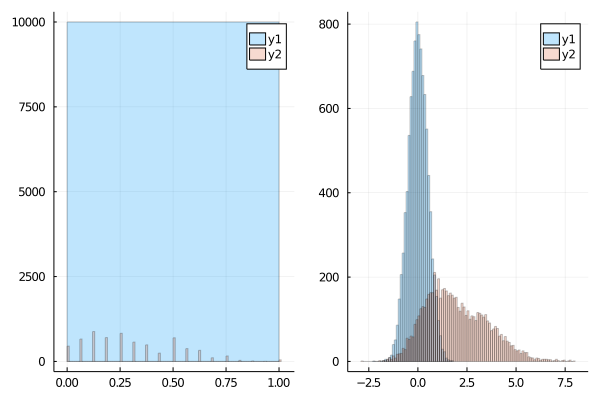

In [8]:
M = 2000
N = 10000
T  =4
g_im = 5
Vle = 1.0
s = 0.1
bins = 100
pop = init_population(N,Vle,s)
# p,g = distributions(pop)
# p1 = Plots.histogram(g, alpha = 0.25)
# p2 = Plots.histogram(p, alpha = 0.25)
# for i in 1:T
#     M = rand(1:500,1)[1]
#     immigration!(pop,M,g_im)
#     reproduce!(pop,N)
#     selection!(pop,s)
    
# #     if i  ==0
# #         p,g = distributions(pop)
# #         p1 = Plots.histogram!(p1,g, alpha = 0.25)
# #         p2 = Plots.histogram!(p2,p, alpha = 0.25)
# #     end 
# end 
# p,g = distributions(pop)
# p1 = Plots.histogram(g, alpha = 0.25,nbins = bins)
# p2 = Plots.histogram(p, alpha = 0.25,nbins = bins)



g_im = 7

pop = init_population(N,Vle,s)
p,g = distributions(pop)
p1 = Plots.histogram(g, alpha = 0.25)
p2 = Plots.histogram(p, alpha = 0.25)
for i in 1:T
    immigration!(pop,M,g_im)
    reproduce!(pop,N)
    selection!(pop,s)
    
    if i  ==0
        p,g = distributions(pop)
        p1 = Plots.histogram!(p1,g, alpha = 0.25)
        p2 = Plots.histogram!(p2,p, alpha = 0.25)
    end 
end 
p,g = distributions(pop)
p1 = Plots.histogram!(p1,g, alpha = 0.25, nbins = bins)
p2 = Plots.histogram!(p2,p, alpha = 0.25,nbins = bins)
plot(p1,p2)

In [120]:
data(pop, "pop_data.csv")

"pop_data.csv"

In [199]:
occursin("H1", "H1W")


true